In [1]:
from rfgap import RFGAP
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from dataset import dataprep, load_regression
from phate import PHATE

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import json

sns.set_theme()

In [2]:
# TODO: Write a module to read in and prepare data from repo

In [3]:
data_names = ['AirfoilSelfNoise', 'AirQuality', 'Automobile', 'AutoMPG',
              'BeijingPM25', 'CommunityCrime', 'ComputerHardware',
              'ConcreateCompressiveStrength', 'ConcreteSlumpTest', 
              'CyclePowerPlant', 'EnergyEfficiency', 'FacebookMetrics',
              'FiveCitiesPM25', 'Hydrodynamics', 'IstanbulStock', 
              'Naval Propulsion Plants', 'OpticalNetwork', 
              'Parkinsons', 'Protein', 'SML2010']

In [4]:
data_name = 'AirfoilSelfNoise'
x, y = load_regression('../datasets/regression/' + data_name)
n, d   = x.shape

In [5]:
# TODO: Add these to RFGAP

def is_in_interval(y, lwr, upr):
    return np.logical_and(y >= lwr, y <= upr)

def get_coverage(y, y_lwr, y_upr):
    return np.mean((y >= y_lwr) & (y <= y_upr))


def get_width_stats(y_lwr, y_upr):
    widths = y_upr - y_lwr
    mean = np.mean(widths)
    sd = np.std(widths)
    min = np.min(widths)
    q1 = np.quantile(widths, 0.25)
    q2 = np.quantile(widths, 0.50)
    q3 = np.quantile(widths, 0.75)
    max = np.max(widths)
    return mean, sd, min, q1, q2, q3, max


In [6]:
x_train, x_test, y_train, y_test, inds_train, inds_test = train_test_split(x, y, np.arange(n), test_size=0.2, random_state = 42)

In [7]:
# Random forest on all data for PHATE embedding visualization
rfphate = RFGAP(oob_score = True, non_zero_diagonal = True, random_state = 42, y = y)
rfphate.fit(x, y)
prox_phate = rfphate.get_proximities()

In [8]:
# Random forest for uncertainty measures; using split datasets
rf = RFGAP(oob_score = True, random_state = 42, y = y)
rf.fit(x_train, y_train)
# prox = rf.get_proximities()

In [9]:
y_pred_test, y_pred_lwr_test, y_pred_upr_test = rf.predict_interval(X_test = x_test,
                                                                    n_neighbors = 'all',
                                                                    level = 0.90)

In [10]:
sort_idx = y_pred_test.argsort()
y_grid = np.linspace(np.min(y_test), np.max(y_test), len(y_test))
is_covered = is_in_interval(y_test, y_pred_lwr_test, y_pred_upr_test)

In [11]:
get_coverage(y_test, y_pred_lwr_test, y_pred_upr_test)

0.8903654485049833

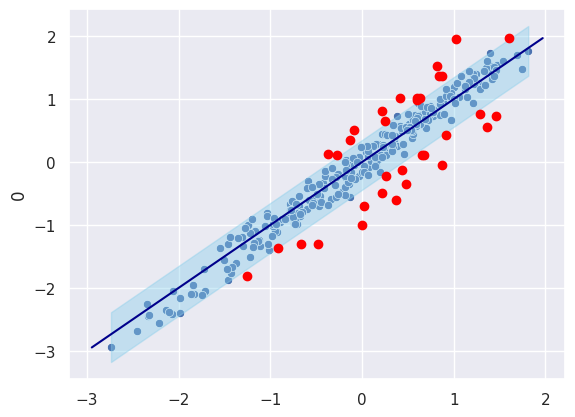

In [12]:
# plt.scatter(y_pred_test, y_test) # Add intervals


sns.scatterplot(x = y_pred_test, y = y_test)
plt.fill_between(np.sort(y_pred_test), y_pred_lwr_test[sort_idx],
                 y_pred_upr_test[sort_idx], color='skyblue', alpha=0.4)

plt.plot(y_grid, y_grid, color = 'darkblue')

plt.scatter(y_pred_test[~is_covered], y_test[~is_covered], color = 'red')




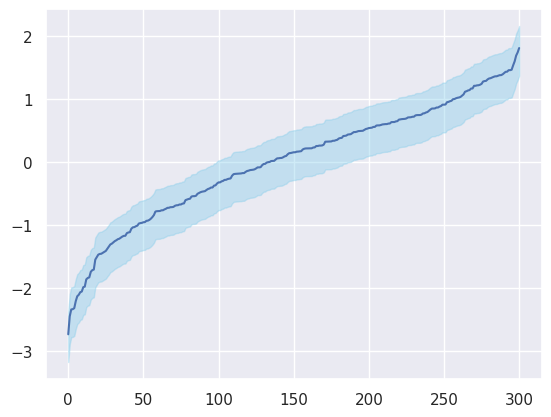

In [13]:
plt.plot(y_pred_test[sort_idx]) # Add intervals
plt.fill_between(range(len(y_test)), y_pred_lwr_test[sort_idx], 
                 y_pred_upr_test[sort_idx], color='skyblue', alpha=0.4, label='Confidence Interval')

In [14]:
# TODO: Run for multiple values of k across multiple datasets. 
# Keep widths, coverages
# Compare with Zhang et al. 2020 and Quantile Regression

In [15]:
import random

random.seed(42)
random_states = [random.randint(0, 10000) for _ in range(10)] 
n_jobs = -1

def interval_loop(data_name = None, n_neighbors = 'auto', level = 0.95, random_state = 42, test_size = 0.2):
    results = {}

    results['data_name'] = data_name
    results['n_neighbors'] = n_neighbors
    results['level'] = level
    results['random_state'] = random_state
    results['test_size'] = test_size

    x, y = load_regression('../datasets/regression/' + data_name)
    n, d   = x.shape
    results['n'] = n
    results['d'] = d

    x_train, x_test, y_train, y_test, inds_train, inds_test = train_test_split(x, y, np.arange(n),
                                                                               test_size = test_size, 
                                                                               random_state = random_state)


    rf = RFGAP(oob_score = True, random_state = random_state, y = y_test)
    rf.fit(x_train, y_train)

    results['oob_score'] = rf.oob_score_
    results['test_score'] = rf.score(x_test, y_test)

    y_pred_test, y_pred_lwr_test, y_pred_upr_test = rf.predict_interval(X_test = x_test,
                                                                    n_neighbors = n_neighbors,
                                                                    level = level)

    results['coverage'] = get_coverage(y_test, y_pred_lwr_test, y_pred_upr_test)

    width_stats = get_width_stats(y_pred_lwr_test, y_pred_upr_test)
    results['width_mean'] = width_stats[0]
    results['width_sd'] = width_stats[1]
    results['width_min'] = width_stats[2]
    results['width_q1'] = width_stats[3]
    results['width_q2'] = width_stats[4]
    results['width_q3'] = width_stats[5]
    results['width_max'] = width_stats[6]

    filename = (data_name + '_' + str(n_neighbors) + '_' + 
            str(level) + '_' + str(random_state) + '_' + 
            str(test_size) + '.json')

    with open(filename, 'w') as f:
        json.dump(results, f)

    return results


    

